# Exploring measures based on information theory

### Introduction
This notebook is part of the collection of biological sequence analyses based on alignment-free distances methods primarily using the Alfpy package. 

In this specific notebook, measures based on information theories (Normalized Compression Distance, Lempel-Ziv complexity) are explored with visualizations using UMAP.

#### **Lempel-Ziv Complexity-Based Distance**



#### **Normalized Compression Distance (NCD)**






#### Work-cited
Zielezinski, A., Vinga, S., Almeida, J. et al. Alignment-free sequence comparison: benefits, applications, and tools. Genome Biol 18, 186 (2017). https://doi.org/10.1186/s13059-017-1319-7

Ming Li, Xin Chen, Xin Li, Bin Ma and P. M. B. Vitanyi, "The similarity metric," in IEEE Transactions on Information Theory, vol. 50, no. 12, pp. 3250-3264, Dec. 2004, doi: 10.1109/TIT.2004.838101.


***
# Quick Access to

#### [Normalized Compression Distance Method](#Normalized-Compression-Distance-(NCD)-Method)
>[Calculate NCD](#calculate-ncd)\
>[MDS and transformation](#mds-transformation)\
>[UMAP](#umap-using-ncd)

***

# Import packages

In [38]:
import pandas as pd
import umap
import umap.plot
import plotly.express as px
import io

from alfpy.utils import seqrecords
from alfpy.utils import distmatrix
from alfpy import ncd
from sklearn.manifold import MDS


from alfpy import word_pattern
from alfpy import word_vector
from alfpy import word_distance

from alfpy.utils import distmatrix

# Import files to analyze

In [39]:
file = open('bacteria-score3-length4.fasta')
seq_records = seqrecords.read_fasta(file)
file.close()

data = pd.read_csv("bacteria-score3-length4.tsv", sep="\t" )

In [40]:
# Check unique types of EC numbers
unique_EC = pd.DataFrame(pd.unique(data["EC number"]))

In [41]:
# Re-sort EC numbers so that all go to only one category
import re
import numpy as np
from copy import deepcopy

pattern1 = "(6\.1\.1\.\d);\s+"
pattern2 = "[^\w\s]+;"
pattern3 = ";\s+(6\.1\.1\.\w)"

copy_row = []



for i, row in data.iterrows():
        # For those with separate functions, disregard the EC that does not start with 6.1.1
    result1 = re.findall(pattern1, row["EC number"])
    result2 = re.findall(pattern2, row["EC number"])
    result3 = re.findall(pattern3, row["EC number"])
    #if result2:
        # change the original EC number to only the ligase one

    if result3:
        data.at[i, "EC number"] = result3[0]

"""   if result1:
        new_row = row.copy()
        new_row["EC number"] = result1[0]
        data.at[i, "EC number"] = result3[0]
"""

pd.DataFrame(pd.unique(data["EC number"]))





,0
0,6.1.1.20
1,6.1.1.2
2,6.1.1.1
3,6.1.1.4
4,6.1.1.14


In [42]:
# Create a dictionary corresponding EC number and their types of aa ligases

ec_typeligases = {
    "6.1.1.1" : "Tyrosine",
    "6.1.1.2" : "Tryptophan",
    "6.1.1.3" : "Threonine",
    "6.1.1.4" : "Leucine",
    "6.1.1.5" : "Isoleucine",
    "6.1.1.6" : "Lysine",
    "6.1.1.7" : "Alanine",
    "6.1.1.9" : "Valine",
    "6.1.1.10" : "Methionine",
    "6.1.1.11" : "Serine",
    "6.1.1.12" : "Aspartate",
    "6.1.1.13" : "D-alanine",
    "6.1.1.14" : "Glycine",
    "6.1.1.15" : "Proline",
    "6.1.1.16" : "Cysteine",
    "6.1.1.17" : "Glutamate",
    "6.1.1.18" : "Glutamine",
    "6.1.1.19" : "Arginine",
    "6.1.1.20" : "Phenylalanine",
    "6.1.1.21" : "Histidine",
    "6.1.1.22" : "Asparagine",
    "6.1.1.23" : "Aspartate-Asn",
    "6.1.1.24" : "Glutamate-Gln",
    "6.1.1.26" : "Pyrrolysine-Pyl",
    "6.1.1.27" : "O-phospho-L-serine",
    "6.1.1.28" : "Proline/cysteine",

    "6.1.1.-": "All_aa"
    
}

ec_classligase = {
    "6.1.1.1" : "I",
    "6.1.1.2" : "I",
    "6.1.1.3" : "IIA",
    "6.1.1.4" : "I",
    "6.1.1.5" : "I",
    "6.1.1.6" : "IIB",
    "6.1.1.7" : "IIC",
    "6.1.1.9" : "I",
    "6.1.1.10" : "I",
    "6.1.1.11" : "IIA",
    "6.1.1.12" : "IIB",
    "6.1.1.13" : "IIC",
    "6.1.1.14" : "IIA",
    "6.1.1.15" : "IIA",
    "6.1.1.16" : "I",
    "6.1.1.17" : "I",
    "6.1.1.18" : "I",
    "6.1.1.19" : "I",
    "6.1.1.20" : "IIC",
    "6.1.1.21" : "II",
    "6.1.1.22" : "IIB",
    "6.1.1.23" : "II",
    "6.1.1.24" : "I", # Not sure if this and below are correct ***
    "6.1.1.26" : "II",
    "6.1.1.27" : "II",
    "6.1.1.28" : "I",

    "6.1.1.-": "XX" # Name the special case

}


In [43]:
# Add the two dictionaries to the dataframe
data["AAs"] = data["EC number"].map(ec_typeligases)
data["Class"] = data["EC number"].map(ec_classligase)

# Check
data.head()
data["AAs"].describe()

count               741
unique                5
top       Phenylalanine
freq                598
Name: AAs, dtype: object

In [44]:
data["Class"].describe()

count     741
unique      3
top       IIC
freq      598
Name: Class, dtype: object

In [45]:
# Add kingdom/taxonomy to the dataframe

# Use regular expression to sort out proteins of different types 

entries = []
types = []
pattern = "(\w+)\s+\(superkingdom\)"

for i, row in data.iterrows():
    result = re.findall(pattern, row["Taxonomic lineage"])
    if result:
        for entry in row["Entry"].split():
            entries.append(entry)
            types.append(result[0])

taxonomies = {}
taxonomies["Entry"] = entries
taxonomies["taxonomy"] = types

taxonomy = pd.DataFrame(taxonomies)

taxonomy

,Entry,taxonomy
0,A0AHW2,Bacteria
1,A0KKP5,Bacteria
2,A0L4K0,Bacteria
3,A0LFC6,Bacteria
4,A0M6W9,Bacteria
...,...,...
736,Q9Z7A4,Bacteria
737,Q9ZD76,Bacteria
738,Q9ZDB5,Bacteria
739,Q9ZJX4,Bacteria


In [46]:
merged_data = pd.merge(data, taxonomy, on="Entry")

merged_data.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,EC number,Taxonomic lineage,Taxonomic lineage (Ids),Sequence,AAs,Class,taxonomy
0,A0AHW2,reviewed,SYFA_LISW6,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS lwe1176,Listeria welshimeri serovar 6b (strain ATCC 35...,350,6.1.1.20,"Listeria welshimeri (species), Listeria (genus...","1643 (species), 1637 (genus), 186820 (family),...",MLEQLQTLKSEAETQIKEASDLKTLNDLRVKYLGKKGPMTEIMKQM...,Phenylalanine,IIC,Bacteria
1,A0KKP5,reviewed,SYFA_AERHH,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS AHA_2323,Aeromonas hydrophila subsp. hydrophila (strain...,327,6.1.1.20,Aeromonas hydrophila subsp. hydrophila (subspe...,"196023 (subspecies), 644 (species), 642 (genus...",MQQLEEVVGQARAEIEGVSDIAALDEIRVKYLGKKGFFTEQMKGLG...,Phenylalanine,IIC,Bacteria
2,A0L4K0,reviewed,SYFA_MAGMM,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS Mmc1_0367,Magnetococcus marinus (strain ATCC BAA-1437 / ...,348,6.1.1.20,"Magnetococcus marinus (species), Magnetococcus...","1124597 (species), 162171 (genus), 1191479 (fa...",MTMRNALQQLEQEAISAISSSENLKDLEDVRIRFMGKKGSITQQYG...,Phenylalanine,IIC,Bacteria
3,A0LFC6,reviewed,SYFA_SYNFM,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS Sfum_0428,Syntrophobacter fumaroxidans (strain DSM 10017...,336,6.1.1.20,"Syntrophobacter fumaroxidans (species), Syntro...","119484 (species), 29526 (genus), 213465 (famil...",MEDAVRKLLNSADHEVLALANDARAIEQLKVRFLGRKGELARLFKE...,Phenylalanine,IIC,Bacteria
4,A0M6W9,reviewed,SYFA_GRAFK,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS GFO_3424,Gramella forsetii (strain KT0803),339,6.1.1.20,"Gramella forsetii (species), Gramella (genus),...","411153 (species), 292691 (genus), 49546 (famil...",MIDKIKGHIADVESFNAKTKDEIEAFRIKYLGKKGILNDFFAEFKN...,Phenylalanine,IIC,Bacteria


In [47]:
# Create another dictionary converting AA's to numbers usable to UMAP

aa_num = {
    "Tyrosine":1,
    "Tryptophan":2,
    "Threonine":3,
    "Leucine":4,
    "Isoleucine":5,
    "Lysine":6,
    "Alanine":7,
    "Valine":9,
    "Methionine":10,
    "Serine":11,
    "Aspartate":12,
    "D-alanine":13,
    "Glycine":14,
    "Proline":15,
    "Cysteine":16,
    "Glutamate":17,
    "Glutamine":18,
    "Arginine":19,
    "Phenylalanine":20,
    "Histidine":21,
    "Asparagine":22,
    "Aspartate-Asn":23,
    "Glutamate-Gln":24,
    "Pyrrolysine-Pyl":26,
    "O-phospho-L-serine":27,
    "Proline/cysteine":28,

    "All_aa":100
    
}

In [48]:
data["transformed_aa"] = data["AAs"].map(aa_num)

data.head()



,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,EC number,Taxonomic lineage,Taxonomic lineage (Ids),Sequence,AAs,Class,transformed_aa
0,A0AHW2,reviewed,SYFA_LISW6,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS lwe1176,Listeria welshimeri serovar 6b (strain ATCC 35...,350,6.1.1.20,"Listeria welshimeri (species), Listeria (genus...","1643 (species), 1637 (genus), 186820 (family),...",MLEQLQTLKSEAETQIKEASDLKTLNDLRVKYLGKKGPMTEIMKQM...,Phenylalanine,IIC,20
1,A0KKP5,reviewed,SYFA_AERHH,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS AHA_2323,Aeromonas hydrophila subsp. hydrophila (strain...,327,6.1.1.20,Aeromonas hydrophila subsp. hydrophila (subspe...,"196023 (subspecies), 644 (species), 642 (genus...",MQQLEEVVGQARAEIEGVSDIAALDEIRVKYLGKKGFFTEQMKGLG...,Phenylalanine,IIC,20
2,A0L4K0,reviewed,SYFA_MAGMM,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS Mmc1_0367,Magnetococcus marinus (strain ATCC BAA-1437 / ...,348,6.1.1.20,"Magnetococcus marinus (species), Magnetococcus...","1124597 (species), 162171 (genus), 1191479 (fa...",MTMRNALQQLEQEAISAISSSENLKDLEDVRIRFMGKKGSITQQYG...,Phenylalanine,IIC,20
3,A0LFC6,reviewed,SYFA_SYNFM,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS Sfum_0428,Syntrophobacter fumaroxidans (strain DSM 10017...,336,6.1.1.20,"Syntrophobacter fumaroxidans (species), Syntro...","119484 (species), 29526 (genus), 213465 (famil...",MEDAVRKLLNSADHEVLALANDARAIEQLKVRFLGRKGELARLFKE...,Phenylalanine,IIC,20
4,A0M6W9,reviewed,SYFA_GRAFK,Phenylalanine--tRNA ligase alpha subunit (EC 6...,pheS GFO_3424,Gramella forsetii (strain KT0803),339,6.1.1.20,"Gramella forsetii (species), Gramella (genus),...","411153 (species), 292691 (genus), 49546 (famil...",MIDKIKGHIADVESFNAKTKDEIEAFRIKYLGKKGILNDFFAEFKN...,Phenylalanine,IIC,20


***

# Normalized Compression Distance (NCD) Method
[Back to top](#Quick-Access-to)

#### Calculate NCD

In [49]:
dist = ncd.Distance(seq_records)
ncd_matrix = distmatrix.create(seq_records.id_list, dist)
#ncd_matrix.display()

In [50]:
# Convert into usable pandas format
ncd = io.StringIO()
ncd_matrix.writer(ncd, 'phylip', 7)

# Get the written string
ncd.seek(0)

# Create pandas dataframe table
ncd_data = pd.read_csv(ncd,sep="\s+",skiprows=[0],header=None,index_col=0)

ncd_data
ncd_data.index.name = None
ncd_data.columns = ncd_data.index # Make the first row (column names) the same as the indeces 
ncd_data


,sp|A0AHW2|,sp|A0KKP5|,sp|A0L4K0|,sp|A0LFC6|,sp|A0M6W9|,sp|A0PZN8|,sp|A0Q6A6|,sp|A0QHB6|,sp|A1A1X6|,sp|A1ARE1|,...,sp|Q9RRX8|,sp|Q9RWV7|,sp|Q9WYW2|,sp|Q9WZS8|,sp|Q9Z6R6|,sp|Q9Z7A4|,sp|Q9ZD76|,sp|Q9ZDB5|,sp|Q9ZJX4|,sp|Q9ZKF9|
sp|A0AHW2|,0.000000,0.853211,0.853881,0.811927,0.862385,0.788991,0.839449,0.876147,0.868182,0.816514,...,0.848624,0.880734,0.889908,0.844037,0.871560,0.885321,0.876147,0.853211,0.885321,0.848624
sp|A0KKP5|,0.853211,0.000000,0.794520,0.819905,0.838095,0.840376,0.695238,0.832536,0.868182,0.830189,...,0.876777,0.880383,0.888889,0.848039,0.859155,0.878505,0.884615,0.825688,0.887255,0.821256
sp|A0L4K0|,0.853881,0.794520,0.000000,0.785388,0.872146,0.863014,0.799087,0.867580,0.881818,0.821918,...,0.872146,0.885845,0.881278,0.821918,0.853881,0.899543,0.885845,0.826484,0.885845,0.821918
sp|A0LFC6|,0.811927,0.819905,0.785388,0.000000,0.834123,0.835681,0.796208,0.853081,0.863636,0.740566,...,0.848341,0.867299,0.876777,0.834123,0.859155,0.887850,0.872038,0.834862,0.881517,0.810427
sp|A0M6W9|,0.862385,0.838095,0.872146,0.834123,0.000000,0.859155,0.838095,0.876190,0.868182,0.830189,...,0.872038,0.885714,0.885714,0.842857,0.840376,0.887850,0.885714,0.866973,0.904762,0.838095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|Q9Z7A4|,0.885321,0.878505,0.899543,0.887850,0.887850,0.878505,0.887850,0.897196,0.886364,0.892523,...,0.883178,0.869159,0.869159,0.887850,0.883178,0.000000,0.878505,0.880734,0.887850,0.878505
sp|Q9ZD76|,0.876147,0.884615,0.885845,0.872038,0.885714,0.877934,0.876190,0.885167,0.881818,0.877359,...,0.886256,0.842105,0.860577,0.875000,0.882629,0.878505,0.000000,0.871560,0.846154,0.870192
sp|Q9ZDB5|,0.853211,0.825688,0.826484,0.834862,0.866973,0.848624,0.830275,0.862385,0.868182,0.848624,...,0.862385,0.862385,0.880734,0.871560,0.866973,0.880734,0.871560,0.000000,0.894495,0.825688
sp|Q9ZJX4|,0.885321,0.887255,0.885845,0.881517,0.904762,0.887324,0.885714,0.904306,0.904546,0.886792,...,0.886256,0.861244,0.888889,0.891626,0.887324,0.887850,0.846154,0.894495,0.000000,0.888889


In [51]:
# Check the dataframe
ncd_values = ncd_data.values
ncd_values.shape

(741, 741)

#### MDS Transformation

In [52]:
# Multidimensional Scaling (MDS)

ncd_mds = MDS(random_state = 0, dissimilarity="precomputed")
ncd_transform = ncd_mds.fit_transform(ncd_values)

/Users/yufeimeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [53]:
# Create pandas dataframe
ncd_pca = pd.DataFrame(ncd_transform, index=seq_records.id_list, columns = ["PC1", "PC2"])
ncd_pca

,PC1,PC2
sp|A0AHW2|SYFA_LISW6,0.224892,0.335933
sp|A0KKP5|SYFA_AERHH,-0.251746,-0.314528
sp|A0L4K0|SYFA_MAGMM,-0.384621,0.166748
sp|A0LFC6|SYFA_SYNFM,-0.053061,0.147053
sp|A0M6W9|SYFA_GRAFK,0.390711,-0.394470
...,...,...
sp|Q9Z7A4|SYW_CHLPN,-0.074920,0.688541
sp|Q9ZD76|SYW_RICPR,-0.384756,0.498493
sp|Q9ZDB5|SYFA_RICPR,-0.072728,-0.609702
sp|Q9ZJX4|SYW_HELPJ,0.047993,0.717743


In [54]:
# Create subset with transformed_aa and entry from data
subset = data[["Entry", "AAs","transformed_aa"]]

# Add the entry column to ncd
ncd_entry = []
for i in seq_records.id_list:
    result = re.findall("\w+\|(\w+)",i)
    ncd_entry.append(result[0])
ncd_pca["Entry"] = ncd_entry

# Merge based on same Entry to add columns AA's, Entry, transformed_aa into the final table
merged_ncd = pd.merge(ncd_pca, subset)

merged_ncd

,PC1,PC2,Entry,AAs,transformed_aa
0,0.224892,0.335933,A0AHW2,Phenylalanine,20
1,-0.251746,-0.314528,A0KKP5,Phenylalanine,20
2,-0.384621,0.166748,A0L4K0,Phenylalanine,20
3,-0.053061,0.147053,A0LFC6,Phenylalanine,20
4,0.390711,-0.394470,A0M6W9,Phenylalanine,20
...,...,...,...,...,...
736,-0.074920,0.688541,Q9Z7A4,Tryptophan,2
737,-0.384756,0.498493,Q9ZD76,Tryptophan,2
738,-0.072728,-0.609702,Q9ZDB5,Phenylalanine,20
739,0.047993,0.717743,Q9ZJX4,Tryptophan,2



#### UMAP using NCD

In [55]:
aa_data_ncd = merged_ncd[
    [
    "PC1",
    "PC2"
    ]
].values

mapper_ncd = umap.UMAP().fit(aa_data_ncd)

<Axes: >

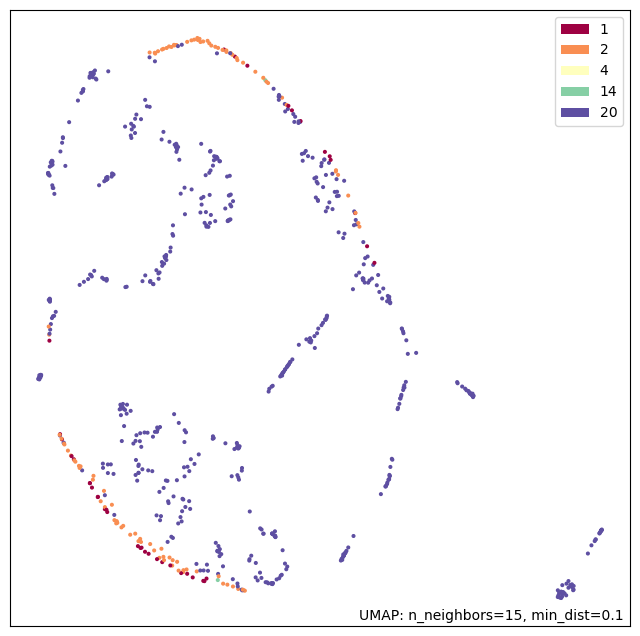

In [56]:
umap.plot.points(mapper_ncd,labels=merged_ncd.transformed_aa)